In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
sys.path.append("../..") # relative path to module toolkit

In [3]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight 
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
# setup
batch_size = 3
train_dir = "../../../images/images_species/train/"
val_dir = "../../../images/images_species/val/"
train_images = 12263
val_images = 3381
save_model_name = "restnet50pretrained.h5"
save_plot_name = "resnet50pretrained_trainplot.png"
model_name = 'resNet50pretrained_highest_val_acc.h5'

In [5]:
steps_per_epoch = int(train_images/batch_size) + 1
validation_steps = int(val_images/batch_size) + 1

In [6]:
### Model building ####

base_model = ResNet50(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet")

#add a new dense layer to the end of the network inplace of the old layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(4096, activation='relu')(x)

# add the outplut layer
predictions = Dense(200, activation='softmax')(x)

# create new model composed of pre-trained network and new final layers
model = Model(input=base_model.input, output=predictions)

for layer in model.layers:
    layer.trainable = True

/home/herri/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/herri/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
# compile model
model.compile(loss='categorical_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])


In [9]:
labels = getLabelsFromDir(train_dir)

train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)

Found 12263 images belonging to 200 classes.
Found 3381 images belonging to 200 classes.


In [11]:
filepath = model_name

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', mode='max', patience=10)

def schedule_func(epoch, lr):
    if lr < 0.0001:
        return lr
    elif epoch % 12 == 0 and epoch > 0:
        return lr * 0.1
    else:
        return lr
    
scheduler = LearningRateScheduler(schedule_func, 1)

callbacks = [checkpoint, early_stop, scheduler]

In [12]:
the_class_weight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

In [13]:
#Train
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=the_class_weight)

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.009999999776482582.
4088/4088 [==============================] - 419s 103ms/step - loss: 2.6188 - acc: 0.3673 - val_loss: 2.2165 - val_acc: 0.4639

Epoch 00001: val_acc improved from -inf to 0.46395, saving model to resNet50pretrained_highest_val_acc.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.009999999776482582.
4088/4088 [==============================] - 403s 98ms/step - loss: 0.9535 - acc: 0.7162 - val_loss: 1.5989 - val_acc: 0.6152

Epoch 00002: val_acc improved from 0.46395 to 0.61525, saving model to resNet50pretrained_highest_val_acc.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.009999999776482582.
4088/4088 [==============================] - 409s 100ms/step - loss: 0.5390 - acc: 0.8355 - val_loss: 2.0180 - val_acc: 0.5842

Epoch 00003: val_acc did not improve from 0.61525
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate t

4088/4088 [==============================] - 399s 98ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.7349 - val_acc: 0.8632

Epoch 00028: val_acc did not improve from 0.86820
Epoch 29/50

Epoch 00029: LearningRateScheduler setting learning rate to 9.99999901978299e-05.
4088/4088 [==============================] - 399s 98ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.7182 - val_acc: 0.8641

Epoch 00029: val_acc did not improve from 0.86820
Epoch 30/50

Epoch 00030: LearningRateScheduler setting learning rate to 9.99999901978299e-05.
4088/4088 [==============================] - 399s 98ms/step - loss: 0.0033 - acc: 0.9998 - val_loss: 0.7176 - val_acc: 0.8673

Epoch 00030: val_acc did not improve from 0.86820
Epoch 31/50

Epoch 00031: LearningRateScheduler setting learning rate to 9.99999901978299e-05.
4088/4088 [==============================] - 399s 98ms/step - loss: 0.0034 - acc: 0.9998 - val_loss: 0.7295 - val_acc: 0.8641

Epoch 00031: val_acc did not improve from 0.86820
Epoch 3

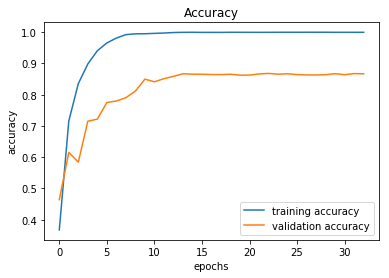

In [14]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(save_plot_name, bbox_inches='tight')
plt.show()

In [15]:
#save
model.save(save_model_name)